#Probing

## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import spacy
import re
import string
import time

import nltk
from nltk import Tree

from collections import Counter
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 6.9 MB/s eta 0:00:01    |████▎                           | 1.6 MB 6.9 MB/s eta 0:00:02
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.7/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


## Set random seed

In [ ]:
SEED = 1

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Preprocess data

### Import data

In [ ]:
tr = pd.read_csv('../input/stanford-natural-language-inference-corpus/snli_1.0_train.csv')
test = pd.read_csv('../input/stanford-natural-language-inference-corpus/snli_1.0_test.csv')
valid = pd.read_csv('../input/stanford-natural-language-inference-corpus/snli_1.0_dev.csv')

### Remove null data points

In [ ]:
tr.isnull().sum()

gold_label                     0
sentence1_binary_parse         0
sentence2_binary_parse         6
sentence1_parse                0
sentence2_parse                0
sentence1                      0
sentence2                      6
captionID                      0
pairID                         0
label1                         0
label2                    510782
label3                    510757
label4                    510769
label5                    513238
dtype: int64

In [ ]:
tr = tr.dropna(subset = ['sentence2'])
tr = tr[tr["gold_label"] != "-"]
test = test[test["gold_label"] != "-"]
valid = valid[valid["gold_label"] != "-"]

In [ ]:
tr.isnull().sum()

gold_label                     0
sentence1_binary_parse         0
sentence2_binary_parse         0
sentence1_parse                0
sentence2_parse                0
sentence1                      0
sentence2                      0
captionID                      0
pairID                         0
label1                         0
label2                    510769
label3                    510740
label4                    510753
label5                    512937
dtype: int64

### Train tokenizer

In [ ]:
tok = spacy.load('en')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [ ]:
counts = Counter()
for index, row in tr.iterrows():
    counts.update(tokenize(row['sentence1']+row['sentence2']))

In [ ]:
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 38910
num_words after: 26602


In [ ]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [ ]:
def encode_sentence(text, vocab2index, N=80):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [ ]:
vocab_size = len(words)
vocab_size

26604

### Process and then encode over the parsed sentence

#### Iterate over the parsed tree to extract words and POS tags

In [ ]:
def encode_parse(tree,tag,word):
    for subtree in tree:
        if (type(subtree) == nltk.tree.Tree):
            encode_parse(subtree,tag,word)
        else:
            enc = (str(tree))
            pos = int(enc.find(' '))
            tag.append(enc[1:pos])
            word.append(str(subtree))

In [ ]:
tags_train=[]
words2_train=[]
for parse in tr['sentence1_parse']:
    tree = Tree.fromstring(parse)
    tag = []
    word = []
    encode_parse(tree,tag,word)
    tag.pop()
    word.pop()
    tags_train.append(tag)
    words2_train.append(word)
for parse in tr['sentence2_parse']:
    tree = Tree.fromstring(parse)
    tag = []
    word = []
    encode_parse(tree,tag,word)
    tag.pop()
    word.pop()
    tags_train.append(tag)
    words2_train.append(word)

In [ ]:
tags_test=[]
words2_test=[]
for parse in test['sentence1_parse']:
    tree = Tree.fromstring(parse)
    tag = []
    word = []
    encode_parse(tree,tag,word)
    tag.pop()
    word.pop()
    tags_test.append(tag)
    words2_test.append(word)
for parse in test['sentence2_parse']:
    tree = Tree.fromstring(parse)
    tag = []
    word = []
    encode_parse(tree,tag,word)
    tag.pop()
    word.pop()
    tags_test.append(tag)
    words2_test.append(word)

In [ ]:
tags_valid=[]
words2_valid=[]
for parse in valid['sentence1_parse']:
    tree = Tree.fromstring(parse)
    tag = []
    word = []
    encode_parse(tree,tag,word)
    tag.pop()
    word.pop()
    tags_valid.append(tag)
    words2_valid.append(word)
for parse in tr['sentence2_parse']:
    tree = Tree.fromstring(parse)
    tag = []
    word = []
    encode_parse(tree,tag,word)
    tag.pop()
    word.pop()
    tags_valid.append(tag)
    words2_valid.append(word)

#### Check length of words and tags

In [ ]:
s=0
for i in tags_train:
    s+=len(i)
print ("Train =", s)

s=0
for i in tags_test:
    s+=len(i)
print ("Test =", s)

s=0
for i in tags_valid:
    s+=len(i)
print ("Valid =", s)

Train = 11142026
Test = 210937
Valid = 4123538


In [ ]:
s=0
for i in words2_train:
    s+=len(i)
print ("Train =", s)

s=0
for i in words2_test:
    s+=len(i)
print ("Train =", s)

s=0
for i in words2_valid:
    s+=len(i)
print ("Train =", s)

Train = 11142026
Train = 210937
Train = 4123538


#### Join words and tags into strings and put them in dataframes

In [ ]:
sentence_train = [' '.join(i) for i in words2_train]
sentence_test = [' '.join(i) for i in words2_test]
sentence_valid = [' '.join(i) for i in words2_valid]

In [ ]:
tag_string_train = [' '.join(i) for i in tags_train]
tag_string_test = [' '.join(i) for i in tags_test]
tag_string_valid = [' '.join(i) for i in tags_valid]

In [ ]:
train_probe = pd.DataFrame(sentence_train, columns =['Sentence'])
test_probe = pd.DataFrame(sentence_test, columns =['Sentence'])
valid_probe = pd.DataFrame(sentence_valid, columns =['Sentence'])

In [ ]:
train_probe.head()

,Sentence
0,A person on a horse jumps over a broken down a...
1,A person on a horse jumps over a broken down a...
2,A person on a horse jumps over a broken down a...
3,Children smiling and waving at
4,Children smiling and waving at


#### Tokenize words using previously trained tokenizer

In [ ]:
train_probe['enc'] = train_probe['Sentence'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
test_probe['enc'] = test_probe['Sentence'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
valid_probe['enc'] = valid_probe['Sentence'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

#### Train tokenizer and tokenize tags

In [ ]:
train_probe['tags'] = tag_string_train
test_probe['tags'] = tag_string_test
valid_probe['tags'] = tag_string_valid

In [ ]:
countstag = Counter()
for index, row in train_probe.iterrows():
    countstag.update(tokenize(row['tags']))

In [ ]:
vocab2indextag = {"":0, "UNK":1}
wordstag = ["", "UNK"]
for word in countstag:
    vocab2indextag[word] = len(wordstag)
    wordstag.append(word)

In [ ]:
tag_length = len(wordstag)
tag_length

45

In [ ]:
train_probe['tag_enc'] = train_probe['tags'].apply(lambda x: np.array(encode_sentence(x,vocab2indextag )))
test_probe['tag_enc'] = test_probe['tags'].apply(lambda x: np.array(encode_sentence(x,vocab2indextag )))
valid_probe['tag_enc'] = valid_probe['tags'].apply(lambda x: np.array(encode_sentence(x,vocab2indextag )))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

In [ ]:
train_probe.head()

,Sentence,enc,tags,tag_enc
0,A person on a horse jumps over a broken down a...,"[[2, 3, 4, 2, 5, 6, 7, 2, 8, 9, 10, 0, 0, 0, 0...",DT NN IN DT NN VBZ IN DT JJ JJ NN,"[[2, 3, 4, 2, 3, 5, 4, 2, 6, 6, 3, 0, 0, 0, 0,..."
1,A person on a horse jumps over a broken down a...,"[[2, 3, 4, 2, 5, 6, 7, 2, 8, 9, 10, 0, 0, 0, 0...",DT NN IN DT NN VBZ IN DT JJ JJ NN,"[[2, 3, 4, 2, 3, 5, 4, 2, 6, 6, 3, 0, 0, 0, 0,..."
2,A person on a horse jumps over a broken down a...,"[[2, 3, 4, 2, 5, 6, 7, 2, 8, 9, 10, 0, 0, 0, 0...",DT NN IN DT NN VBZ IN DT JJ JJ NN,"[[2, 3, 4, 2, 3, 5, 4, 2, 6, 6, 3, 0, 0, 0, 0,..."
3,Children smiling and waving at,"[[23, 24, 25, 26, 16, 0, 0, 0, 0, 0, 0, 0, 0, ...",NNP VBG CC VBG IN,"[[7, 8, 9, 8, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Children smiling and waving at,"[[23, 24, 25, 26, 16, 0, 0, 0, 0, 0, 0, 0, 0, ...",NNP VBG CC VBG IN,"[[7, 8, 9, 8, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
tag_enc_train = []
for i in train_probe['tag_enc']:
    tag_enc_train.append(i[0])
    
tag_enc_test = []
for i in test_probe['tag_enc']:
    tag_enc_test.append(i[0])
    
tag_enc_valid = []
for i in valid_probe['tag_enc']:
    tag_enc_valid.append(i[0])

## Prepare Datasets and load them into Dataloaders

In [ ]:
class ProbeDataset(Dataset):
    def __init__(self, X1, Y):
        self.X1 = X1
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X1[idx][0].astype(np.int32)), self.y[idx]

In [ ]:
train_probe_ds = ProbeDataset(train_probe['enc'],tag_enc_train)
test_probe_ds = ProbeDataset(test_probe['enc'],tag_enc_test)
valid_probe_ds = ProbeDataset(valid_probe['enc'],tag_enc_valid)

In [ ]:
len(test_probe)

19648

In [ ]:
train_probe_dl = DataLoader(train_probe_ds, batch_size=2048*4, shuffle=True)
test_probe_dl = DataLoader(test_probe_ds, batch_size=2048*4, shuffle=True)
valid_probe_dl = DataLoader(valid_probe_ds, batch_size=2048*4, shuffle=True)

## Activate GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
print(device)

cuda


### Move Dataloaders to GPU

In [ ]:
train_probe_dl = DeviceDataLoader(train_probe_dl, device)
test_probe_dl = DeviceDataLoader(test_probe_dl, device)
valid_probe_dl = DeviceDataLoader(valid_probe_dl, device)

## Prepare models

### Inference model using BiLSTM

In [ ]:
class Model(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, 512, padding_idx=0)
        self.trans = nn.Linear(512,128)
        self.lstm = nn.LSTM(128, 128, batch_first=True,num_layers =2, bidirectional = True)
        self.linear1 = nn.Linear(512, 1024)
        self.linear2 = nn.Linear(1024, 256)
        self.linear3 = nn.Linear(256, 64)
        self.linear4 = nn.Linear(64, 16)
        self.linear5 = nn.Linear(16, 3)
        self.dropout = nn.Dropout(0.2)
        self.out = nn.LogSoftmax(dim=1)
        
    def forward(self, x1, x2):
        
        x1 = self.embeddings(x1)
        x1 = self.trans(x1)
        x1 = self.dropout(x1)
        _,(x1,_) = self.lstm(x1)
        
        x2 = self.embeddings(x2)
        x2 = self.trans(x2)
        x2 = self.dropout(x2)
        _,(x2,_) = self.lstm(x2)
        
        x1 = torch.cat((x1[-1], x1[-2]), dim=-1)
        x2 = torch.cat((x2[-1], x2[-2]), dim=-1)

        combined = torch.cat((x1, x2), dim=1)
        
        combined = F.relu(self.linear1(combined))
        combined = self.dropout(combined)
        
        combined = F.relu(self.linear2(combined))
        combined = self.dropout(combined)
        
        combined = F.relu(self.linear3(combined))
        combined = self.dropout(combined)
        
        combined = F.relu(self.linear4(combined))
        combined = self.dropout(combined)
        
        combined = F.relu(self.linear5(combined))
        combined = self.out(combined)
        
        return combined

In [ ]:
model =  Model()
model = to_device(model, device)

#### Load previously trained weights

In [ ]:

if torch.cuda.is_available():
    model.load_state_dict(torch.load('../input/nlp-weight/trained-nlp-model-weigth-79.pt'))
else:
    model.load_state_dict(torch.load('../input/nlp-weight/trained-nlp-model-weigth-79.pt', map_location=torch.device('cpu')))


### Probe Model

In [ ]:
class ProbeModel(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.embeddings = model.embeddings
        for param in model.parameters():
            param.requires_grad = False #Freeze embedding parameters from inital model
        self.linear1 = nn.Linear(512, 128)
        self.linear2 = nn.Linear(128, tag_length)
        self.dropout = nn.Dropout(0.2)
        self.out = nn.LogSoftmax(dim=1)
        
    def forward(self, x1):
        
        x1 = self.embeddings(x1)
        
        x1 = self.linear1(x1)
        x1 = self.dropout(x1)
        x1 = self.linear2(x1)
        op = self.out(x1)
        s = op.shape
        op = op.reshape(s[0],s[2],s[1])
        return op

In [ ]:
model_probe =  ProbeModel()
model_probe = to_device(model_probe, device)

#### Check output

In [ ]:
for batch in train_probe_dl:
    with torch.no_grad():
        model_probe.eval()
        word,labels = batch
        word = word.long()
        out = (model_probe(word))
        print(out.shape)
        break
        
for batch in test_probe_dl:
    with torch.no_grad():
        model_probe.eval()
        word,labels = batch
        word = word.long()
        out = (model_probe(word))
        print(out.shape)
        break
        
for batch in valid_probe_dl:
    with torch.no_grad():
        model_probe.eval()
        word,labels = batch
        word = word.long()
        out = (model_probe(word))
        print(out.shape)
        break

torch.Size([8192, 45, 80])
torch.Size([8192, 45, 80])
torch.Size([8192, 45, 80])


#### Choosing loss and optimizer

In [ ]:
criterion = nn.NLLLoss().to(device)
parameters = filter(lambda p: p.requires_grad, model_probe.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.0005)

## Probing

### Defining accuracy, evaluation and training functions

In [ ]:
def categorical_accuracy(preds, y):
    
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    correct = correct.to('cpu')
    y = y.to('cpu')
    return correct.sum() / ( torch.FloatTensor([y.shape[0]]) * torch.FloatTensor([y.shape[1]]) )

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:

            word,labels = batch
            word = word.long()
            labels = labels.long()
        
            predictions = model(word)
            
            loss = criterion(predictions, labels)
                
            acc = categorical_accuracy(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        word,labels = batch
        word = word.long()
        labels = labels.long()
        
        optimizer.zero_grad()
        
        #prem = [prem sent len, batch size]
        #hypo = [hypo sent len, batch size]
        
        predictions = model(word)
        
        #predictions = [batch size, output dim]
        #labels = [batch size]
        
        loss = criterion(predictions, labels)
                
        acc = categorical_accuracy(predictions, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training

In [ ]:
N_EPOCHS = 8
tr_loss = []
vl_loss = []
tr_acc = []
vl_acc = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_probe, train_probe_dl, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model_probe, valid_probe_dl, criterion)
    
    tr_loss.append(train_loss)
    vl_loss.append(valid_loss)
    tr_acc.append(train_acc)
    vl_acc.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_probe.state_dict(), 'probe1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 49s
	Train Loss: 2.805 | Train Acc: 51.18%
	 Val. Loss: 2.096 |  Val. Acc: 66.70%
Epoch: 02 | Epoch Time: 0m 48s
	Train Loss: 2.274 | Train Acc: 59.74%
	 Val. Loss: 2.004 |  Val. Acc: 67.85%
Epoch: 03 | Epoch Time: 0m 48s
	Train Loss: 2.227 | Train Acc: 60.42%
	 Val. Loss: 1.993 |  Val. Acc: 67.96%
Epoch: 04 | Epoch Time: 0m 49s
	Train Loss: 2.213 | Train Acc: 60.69%
	 Val. Loss: 1.980 |  Val. Acc: 68.19%
Epoch: 05 | Epoch Time: 0m 49s
	Train Loss: 2.207 | Train Acc: 60.83%
	 Val. Loss: 1.982 |  Val. Acc: 68.12%
Epoch: 06 | Epoch Time: 0m 48s
	Train Loss: 2.203 | Train Acc: 60.94%
	 Val. Loss: 1.980 |  Val. Acc: 68.05%
Epoch: 07 | Epoch Time: 0m 48s
	Train Loss: 2.201 | Train Acc: 61.03%
	 Val. Loss: 1.978 |  Val. Acc: 68.26%
Epoch: 08 | Epoch Time: 0m 49s
	Train Loss: 2.199 | Train Acc: 61.11%
	 Val. Loss: 1.977 |  Val. Acc: 68.13%


In [ ]:
model_probe.load_state_dict(torch.load('probe1-model.pt'))

test_loss, test_acc = evaluate(model_probe, test_probe_dl, criterion)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test Loss: 2.218 |  Test Acc: 61.09%


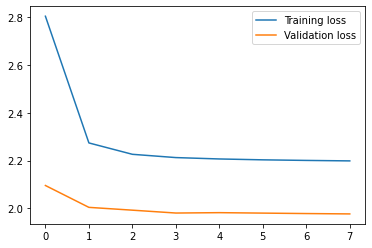

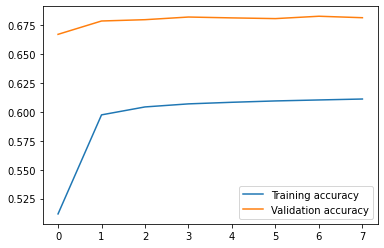

In [ ]:
plt.plot(tr_loss, label = "Training loss")
plt.plot(vl_loss, label = "Validation loss")
plt.legend()
plt.show()

plt.plot(tr_acc, label = "Training accuracy")
plt.plot(vl_acc, label = "Validation accuracy")
plt.legend()
plt.show()